In [1]:
import numpy as np

import torch
import torchvision
from torch import nn

from tqdm import tqdm

from utilities import gpu_util as gp
from utilities import visualize as vs
from utilities import distros as ds
from utilities import base_models as bm

from matplotlib import pyplot as plt

In [2]:
%matplotlib inline
torch.backends.cudnn.benchmark = True

In [3]:
batch_size = 128

transform = torchvision.transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

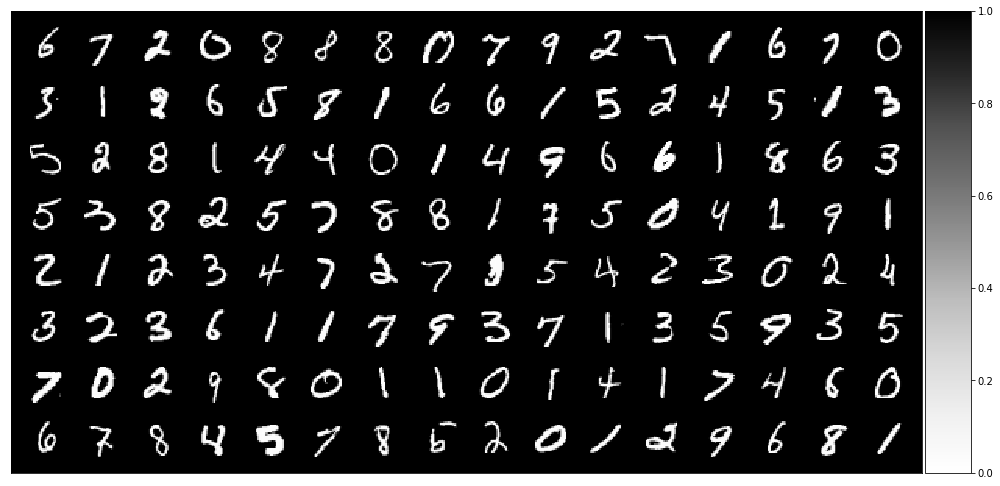

In [4]:
data, _ = next(iter(train_loader))
vs.plot_tensor(data, nrow = 16)

In [5]:
use_gpu = torch.cuda.is_available()

if use_gpu:
    print("Using GPU: {0:s} - {1:0.3f} GB".format(torch.cuda.get_device_name(0), 
                                                  gp.get_gpu_memory_total() / 1000))
    device = torch.device('cuda') 
else:
    print("Using CPU")
    device = torch.device('cpu')

Using GPU: Quadro M4000 - 8.126 GB


In [6]:
ndim = 2
num_labels = 0

lam = 0.1

encoder = bm.Encoder_MNIST(ndim).to(device)
decoder = bm.Decoder_MNIST(ndim).to(device)
discriminator = bm.Discriminator_MNIST(ndim, num_labels).to(device)

encoder_solver = torch.optim.Adam(encoder.parameters(), lr = 1e-3)
decoder_solver = torch.optim.Adam(decoder.parameters(), lr = 1e-3)
discriminator_solver = torch.optim.Adam(discriminator.parameters(), lr = 1e-3)

recon_criterion = nn.MSELoss()
discriminator_criterion = nn.BCEWithLogitsLoss() 
generator_criterion = nn.BCEWithLogitsLoss()

In [7]:
recon = []
disrm = []


for epoch in range(45):

    tot_recon_loss = np.float32(0.)
    tot_discrim_loss = np.float32(0.)
    
    pbar = tqdm(train_loader, miniters = 10, leave = True, ncols = 100, 
        bar_format="{postfix[0][epoch]:02d} {bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining},\
{rate_inv_fmt}] R Loss:{postfix[0][rloss]:>8.5e}, D Loss:{postfix[0][dloss]:>8.5e}",
        postfix=[dict(epoch = epoch, dloss = 0., rloss = 0.)])
    
    for batch_idx, (data, target) in enumerate(pbar):

        num_smpl = data.size(0)
        
        data = data.to(device)
        
        sample_enc = encoder(data)
        sample_tru = torch.tensor(ds.multivariate_standard_normal((num_smpl, ndim)),
                                  dtype = torch.float32, requires_grad = True, device = device)
        
        ones_labels = torch.ones(data.size(0), 1, dtype = torch.float32, 
                                 requires_grad = False, device = device)
        zeros_labels = torch.zeros(data.size(0), 1, dtype = torch.float32,
                                   requires_grad = False, device = device)

        discrim_enc = discriminator(sample_enc)
        discrim_tru = discriminator(sample_tru)

        data_recon = decoder(sample_enc)

        discriminator_solver.zero_grad()

        discrim_loss = lam * (discriminator_criterion(discrim_tru, ones_labels) \
                              + discriminator_criterion(discrim_enc, zeros_labels))

        discrim_loss.backward(retain_graph=True)
        discriminator_solver.step()

        encoder_solver.zero_grad()
        decoder_solver.zero_grad()

        recon_loss = recon_criterion(data_recon, data) \
                     + lam * generator_criterion(discrim_enc, ones_labels)

        recon_loss.backward()

        encoder_solver.step()
        decoder_solver.step()
        
        tot_recon_loss += recon_loss.item() * num_smpl
        tot_discrim_loss += discrim_loss.item() * num_smpl

        if batch_idx < (len(train_loader) - 1):
            pbar.postfix[0]["dloss"] = discrim_loss.item()
            pbar.postfix[0]["rloss"] = recon_loss.item()
        else:
            tot_recon_loss /= len(train_loader.dataset)
            tot_discrim_loss /= len(train_loader.dataset)

            pbar.postfix[0]["dloss"] = tot_discrim_loss.item()
            pbar.postfix[0]["rloss"] = tot_recon_loss.item()
            
    recon.append(tot_recon_loss)
    disrm.append(tot_discrim_loss)

00 ██████████████████████████ 469/469 [00:09<00:00, 0.02s/it] R Loss:1.74037e-01, D Loss:1.59585e-01
01 ██████████████████████████ 469/469 [00:08<00:00, 0.02s/it] R Loss:1.30484e-01, D Loss:1.41683e-01
02 ██████████████████████████ 469/469 [00:09<00:00, 0.02s/it] R Loss:1.23764e-01, D Loss:1.40459e-01
03 ██████████████████████████ 469/469 [00:08<00:00, 0.02s/it] R Loss:1.19835e-01, D Loss:1.38811e-01
04 ██████████████████████████ 469/469 [00:08<00:00, 0.02s/it] R Loss:1.17718e-01, D Loss:1.38806e-01
05 ██████████████████████████ 469/469 [00:08<00:00, 0.02s/it] R Loss:1.15810e-01, D Loss:1.38750e-01
06 ██████████████████████████ 469/469 [00:08<00:00, 0.02s/it] R Loss:1.14256e-01, D Loss:1.38641e-01
07 ██████████████████████████ 469/469 [00:08<00:00, 0.02s/it] R Loss:1.13262e-01, D Loss:1.38662e-01
08 ██████████████████████████ 469/469 [00:08<00:00, 0.02s/it] R Loss:1.12535e-01, D Loss:1.38685e-01
09 ██████████████████████████ 469/469 [00:08<00:00, 0.02s/it] R Loss:1.11867e-01, D Loss:1.

In [8]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=30000, shuffle=True)

In [9]:
data, target = next(iter(test_loader))
data = data.to(device)

num_smpl = data.size(0)

sample_enc = encoder(data)
sample_tru = torch.tensor(ds.multivariate_standard_normal((num_smpl, ndim)),
                          dtype = torch.float32, requires_grad = True, device = device)

discrim_enc = discriminator(sample_enc)
discrim_tru = discriminator(sample_tru)

data_recon = decoder(sample_enc)

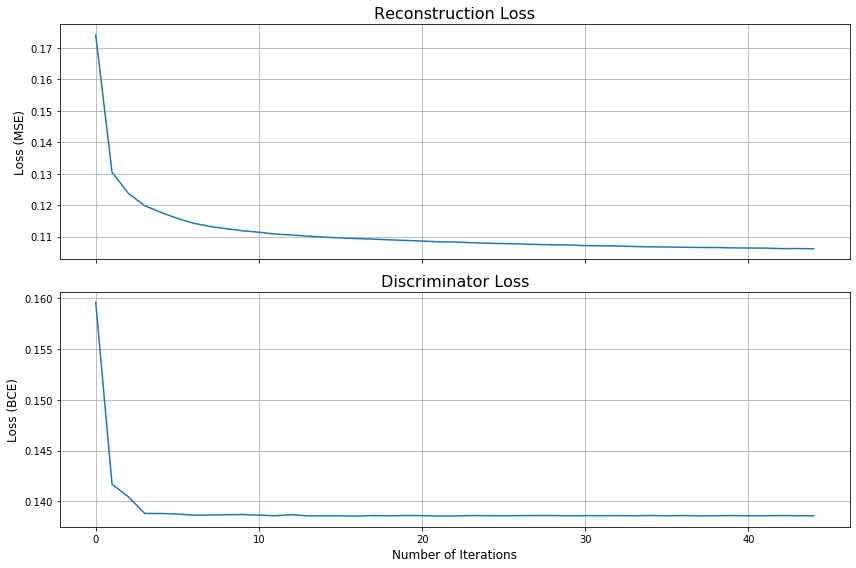

In [10]:
fig, ax = plt.subplots(figsize=(12,8), ncols = 1, nrows = 2, sharex = True)

ax[0].plot(recon)
ax[1].plot(disrm)

#ax[0].set_yscale('log')
#ax[1].set_yscale('log')

ax[0].grid()
ax[1].grid()

ax[0].set_title("Reconstruction Loss", fontsize = 16)
ax[1].set_title("Discriminator Loss", fontsize = 16)

ax[1].set_xlabel("Number of Iterations", fontsize = 12)

ax[0].set_ylabel("Loss (MSE)", fontsize = 12)
ax[1].set_ylabel("Loss (BCE)", fontsize = 12)

plt.tight_layout()

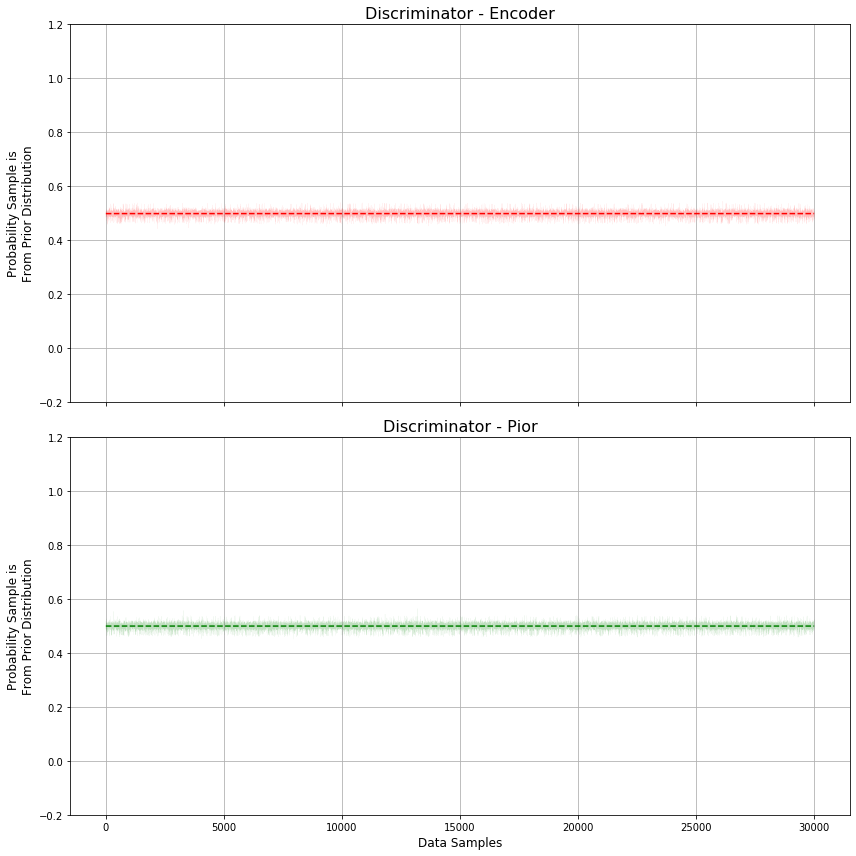

In [11]:
fig, ax = plt.subplots(figsize=(12, 12), ncols = 1, nrows = 2, sharex = True)

de = torch.sigmoid(discrim_enc).detach().cpu().numpy()
dp = torch.sigmoid(discrim_tru).detach().cpu().numpy()

ax[0].plot(de, linewidth = 0.1, color = 'red', alpha = 0.25)
ax[0].plot(de.mean() * np.ones_like(de), linewidth = 1.5, color = 'red', linestyle='--')

ax[1].plot(dp, linewidth = 0.1, color = 'green', alpha = 0.25)
ax[1].plot(dp.mean() * np.ones_like(dp), linewidth = 1.5, color = 'green', linestyle='--')

ax[0].grid()
ax[1].grid()

ax[0].set_title("Discriminator - Encoder", fontsize = 16)
ax[1].set_title("Discriminator - Pior", fontsize = 16)

ax[1].set_xlabel("Data Samples", fontsize = 12)
ax[0].set_ylabel("Probability Sample is\nFrom Prior Distribution", fontsize = 12)
ax[1].set_ylabel("Probability Sample is\nFrom Prior Distribution", fontsize = 12)

ax[0].set_ylim([-0.2,1.2])
ax[1].set_ylim([-0.2,1.2])

plt.tight_layout()


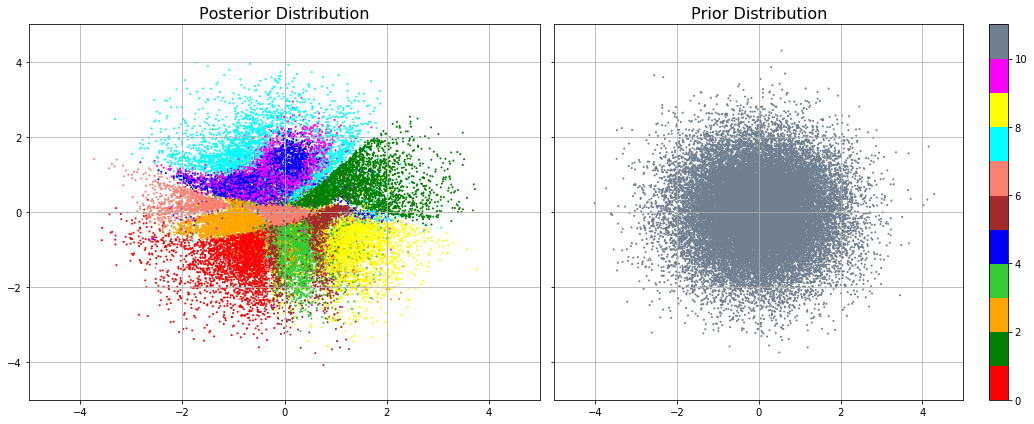

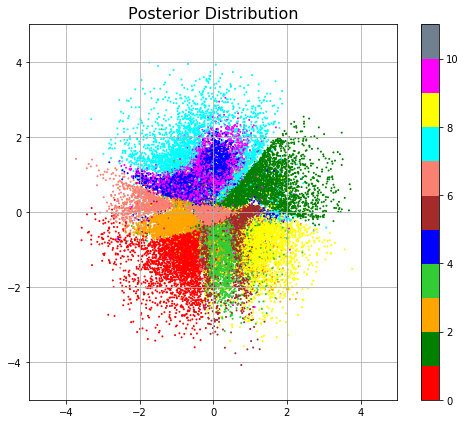

In [12]:
coord1 = sample_enc.detach().cpu().numpy()
coord2 = sample_tru.detach().cpu().numpy()

vs.view_2dDistro((coord1, target.detach().numpy()), 
                 (coord2, np.ones(num_smpl) * 11),
                 figsize = (15,6))

vs.view_2dDistro((coord1, target.detach().numpy()),
                 figsize = (7,6))

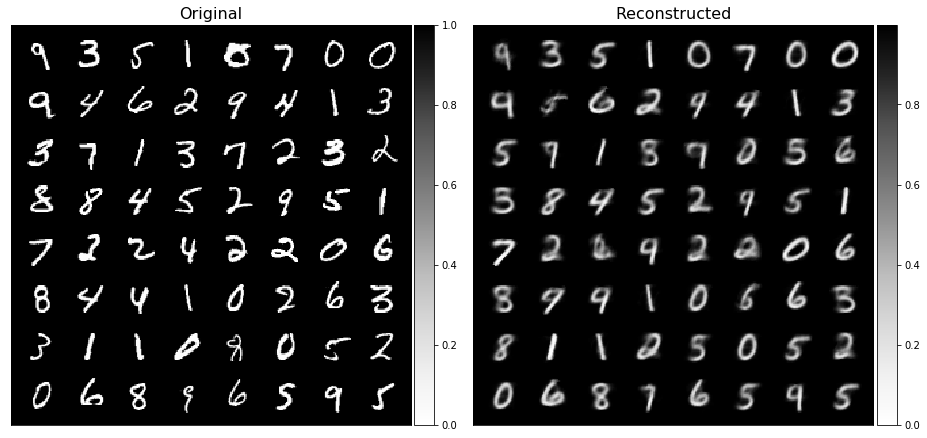

In [13]:
choice = np.random.choice(np.arange(data.size(0)), 64, replace = False)

vs.plot_tensor(data[choice].detach().cpu(), 
               data_recon[choice].detach().cpu(), 
               titles = ["Original", "Reconstructed"], figsize = (13,6))

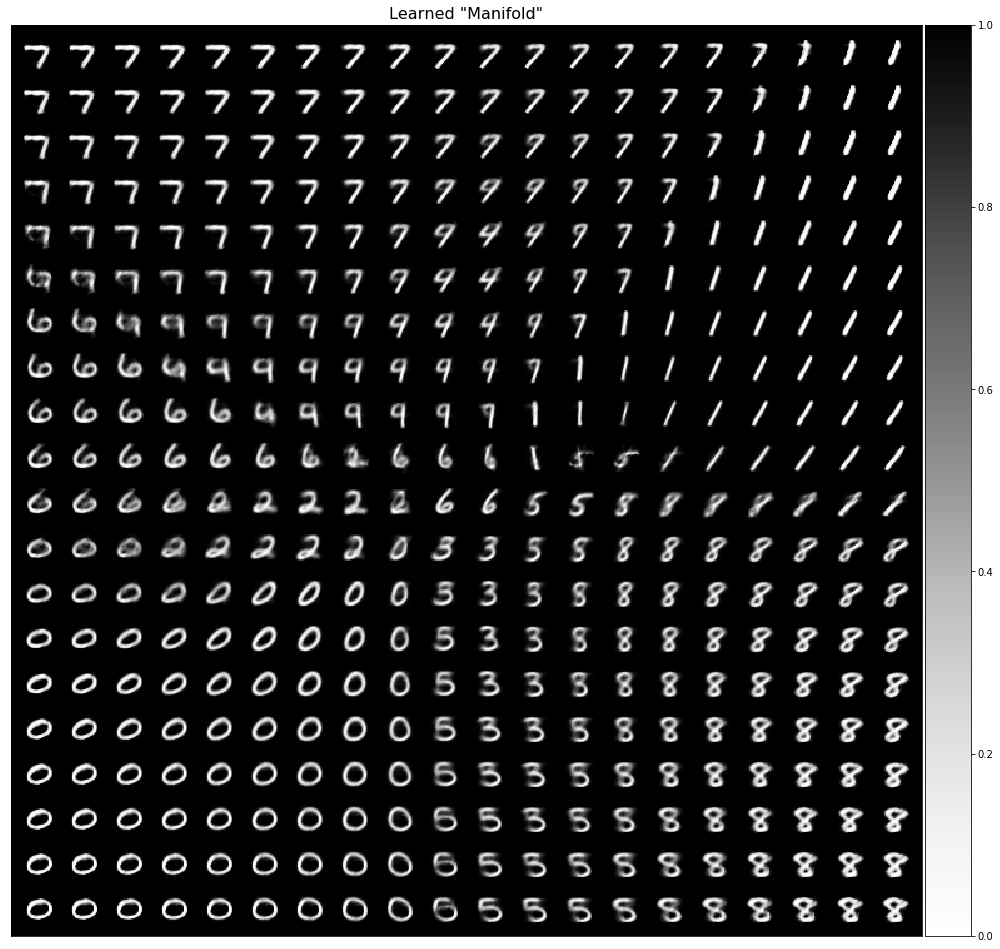

In [14]:
min_smpl = -3
max_smpl = 3
nrow = 20

x1 = np.linspace(min_smpl, max_smpl, nrow).astype('f4')
x2 = np.linspace(min_smpl, max_smpl, nrow).astype('f4')[::-1]

X1, X2 = np.meshgrid(x1,x2,indexing='xy')

smpl = torch.from_numpy(np.c_[X1.ravel(), X2.ravel()]).cuda()

img = decoder(smpl).view(-1, 1, 28, 28).detach().cpu()
vs.plot_tensor(img, nrow = nrow, figsize = (11, 11), titles = ['Learned "Manifold"'])